## Resnet on CIFAR100

在[resnet.ipynb](./resnet.ipynb)中我们测试了Resnet在Imagenette上的分类任务, Imagenette是只包含10类的ImageNet的子集,这里我们在CIFAR100上测试对比不同的Resnet网络效果.

CIFAR-100（加拿大高级研究所）数据集是 CIFAR-10 数据集的重要扩展，由100个不同类别的 60,000 张 32x32 彩色图像组成。它由 CIFAR 研究所的研究人员开发，为更复杂的机器学习和计算机视觉任务提供了更具挑战性的数据集。

随即挑选的10个类别:

![alt text](resources/cifar100.png "Title")

In [1]:
# 自动重新加载外部module，使得修改代码之后无需重新import
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

from hdd.device.utils import get_device

import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms

# 设置训练数据的路径
DATA_ROOT = "~/workspace/hands-dirty-on-dl/dataset"
# 设置TensorBoard的路径
TENSORBOARD_ROOT = "~/workspace/hands-dirty-on-dl/dataset"
# 设置预训练模型参数路径
TORCH_HUB_PATH = "~/workspace/hands-dirty-on-dl/pretrained_models"
torch.hub.set_dir(TORCH_HUB_PATH)
# 挑选最合适的训练设备
DEVICE = get_device(["cuda", "cpu"])
print("Use device: ", DEVICE)

Use device:  cuda


In [2]:
from hdd.data_util.transforms import RandomResize

# 我们提前计算好了训练数据集上的均值和方差
TRAIN_MEAN = [0.50707516, 0.48654887, 0.44091784]
TRAIN_STD = [0.26733429, 0.25643846, 0.27615047]

train_dataset_transforms = transforms.Compose(
    [
        RandomResize([34, 36, 38, 40, 42, 44]),  # 随机在三个size中选择一个进行resize
        transforms.RandomRotation(3),
        transforms.RandomCrop(32),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize(mean=TRAIN_MEAN, std=TRAIN_STD),
    ]
)
# 加载数据集
train_dataset = datasets.CIFAR100(
    root=DATA_ROOT,
    train=True,
    transform=train_dataset_transforms,
    download=True,
)
val_dataset = datasets.CIFAR100(
    root=DATA_ROOT,
    train=False,
    transform=transforms.Compose(
        [transforms.ToTensor(), transforms.Normalize(TRAIN_MEAN, TRAIN_STD)]
    ),
    download=True,
)
print("Basic Info of train dataaset: \n", train_dataset)
print("Basic Info of test dataset: \n", val_dataset)
BATCH_SIZE = 64
train_dataloader = torch.utils.data.DataLoader(
    train_dataset,
    batch_size=BATCH_SIZE,
    shuffle=True,
)
val_dataloader = torch.utils.data.DataLoader(
    val_dataset,
    batch_size=BATCH_SIZE,
    shuffle=False,
)

Files already downloaded and verified
Files already downloaded and verified
Basic Info of train dataaset: 
 Dataset CIFAR100
    Number of datapoints: 50000
    Root location: /home/tf/workspace/hands-dirty-on-dl/dataset
    Split: Train
    StandardTransform
Transform: Compose(
               RandomResize(size=[34, 36, 38, 40, 42, 44], interpolation=bilinear, max_size=None, antialias=True)
               RandomRotation(degrees=[-3.0, 3.0], interpolation=nearest, expand=False, fill=0)
               RandomCrop(size=(32, 32), padding=None)
               RandomHorizontalFlip(p=0.5)
               ToTensor()
               Normalize(mean=[0.50707516, 0.48654887, 0.44091784], std=[0.26733429, 0.25643846, 0.27615047])
           )
Basic Info of test dataset: 
 Dataset CIFAR100
    Number of datapoints: 10000
    Root location: /home/tf/workspace/hands-dirty-on-dl/dataset
    Split: Test
    StandardTransform
Transform: Compose(
               ToTensor()
               Normalize(mean=[0.507

## 测试比较不同的Resnet架构

In [3]:
from spacy import training
from hdd.models.cnn.resnet import ResnetSmall, resnet18_config
from hdd.train.early_stopping import EarlyStoppingInMem
from hdd.train.classification_utils import (
    naive_train_classification_model,
    eval_image_classifier,
)
from hdd.models.nn_utils import count_trainable_parameter


def train_net(
    resnet_config,
    train_dataloader,
    val_dataloader,
    dropout,
    lr,
    weight_decay,
    step_size=70,
    gamma=0.1,
    patience=80,
    max_epochs=280,
) -> tuple[ResnetSmall, dict[str, list[float]]]:
    net = ResnetSmall(resnet_config, num_classes=100, dropout=dropout).to(DEVICE)
    criteria = nn.CrossEntropyLoss()
    # SGD的收敛速度远不如Adam好
    # optimizer = torch.optim.SGD(
    #     net.parameters(), lr=lr, momentum=0.9, weight_decay=weight_decay
    # )
    optimizer = optim.AdamW(
        net.parameters(), lr=lr, eps=1e-6, weight_decay=weight_decay
    )
    scheduler = torch.optim.lr_scheduler.StepLR(
        optimizer, step_size=step_size, gamma=gamma, last_epoch=-1
    )
    early_stopper = EarlyStoppingInMem(patience=patience, verbose=False)
    training_stats = naive_train_classification_model(
        net,
        criteria,
        max_epochs,
        train_dataloader,
        val_dataloader,
        DEVICE,
        optimizer,
        scheduler,
        early_stopper,
        verbose=True,
    )
    return net, training_stats


net, resnet18_stats = train_net(
    resnet18_config,
    train_dataloader,
    val_dataloader,
    dropout=0.5,
    lr=0.01,
    weight_decay=1e-2,
)

eval_result = eval_image_classifier(net, val_dataloader.dataset, DEVICE)
ss = [result.gt_label == result.predicted_label for result in eval_result]
print(f"#Parameter: {count_trainable_parameter(net)} Accuracy: {sum(ss) / len(ss)}")

Epoch: 1/280 Train Loss: 4.0435 Accuracy: 0.0754 Time: 13.68249  | Val Loss: 3.6238 Accuracy: 0.1338
Epoch: 2/280 Train Loss: 3.5900 Accuracy: 0.1449 Time: 12.49647  | Val Loss: 3.2665 Accuracy: 0.2010
Epoch: 3/280 Train Loss: 3.3088 Accuracy: 0.1981 Time: 12.53381  | Val Loss: 2.9849 Accuracy: 0.2619
Epoch: 4/280 Train Loss: 3.0510 Accuracy: 0.2419 Time: 12.97166  | Val Loss: 2.7808 Accuracy: 0.2937
Epoch: 5/280 Train Loss: 2.8054 Accuracy: 0.2900 Time: 12.42250  | Val Loss: 2.5803 Accuracy: 0.3359
Epoch: 6/280 Train Loss: 2.5945 Accuracy: 0.3317 Time: 12.42958  | Val Loss: 2.3953 Accuracy: 0.3798
Epoch: 7/280 Train Loss: 2.4273 Accuracy: 0.3682 Time: 12.38133  | Val Loss: 2.3451 Accuracy: 0.3924
Epoch: 8/280 Train Loss: 2.2999 Accuracy: 0.3952 Time: 12.40817  | Val Loss: 2.1389 Accuracy: 0.4342
Epoch: 9/280 Train Loss: 2.1937 Accuracy: 0.4180 Time: 12.98203  | Val Loss: 2.0193 Accuracy: 0.4604
Epoch: 10/280 Train Loss: 2.0942 Accuracy: 0.4433 Time: 13.12972  | Val Loss: 2.0900 Accura

In [4]:
from hdd.models.cnn.resnet import resnet34_config

net, resnet34_stats = train_net(
    resnet34_config,
    train_dataloader,
    val_dataloader,
    dropout=0.5,
    lr=0.01,
    weight_decay=1e-2,
)

eval_result = eval_image_classifier(net, val_dataloader.dataset, DEVICE)
ss = [result.gt_label == result.predicted_label for result in eval_result]
print(f"#Parameter: {count_trainable_parameter(net)} Accuracy: {sum(ss) / len(ss)}")

Epoch: 1/280 Train Loss: 4.0897 Accuracy: 0.0696 Time: 18.51071  | Val Loss: 3.6693 Accuracy: 0.1304
Epoch: 2/280 Train Loss: 3.6279 Accuracy: 0.1400 Time: 18.50532  | Val Loss: 3.2372 Accuracy: 0.2079
Epoch: 3/280 Train Loss: 3.3119 Accuracy: 0.1935 Time: 18.66785  | Val Loss: 2.9802 Accuracy: 0.2569
Epoch: 4/280 Train Loss: 3.0319 Accuracy: 0.2424 Time: 18.54803  | Val Loss: 2.9218 Accuracy: 0.2700
Epoch: 5/280 Train Loss: 2.8046 Accuracy: 0.2878 Time: 18.51891  | Val Loss: 2.4757 Accuracy: 0.3475
Epoch: 6/280 Train Loss: 2.6241 Accuracy: 0.3244 Time: 18.59367  | Val Loss: 2.4744 Accuracy: 0.3574
Epoch: 7/280 Train Loss: 2.4662 Accuracy: 0.3567 Time: 18.56074  | Val Loss: 2.2597 Accuracy: 0.4060
Epoch: 8/280 Train Loss: 2.3434 Accuracy: 0.3858 Time: 18.52589  | Val Loss: 2.3390 Accuracy: 0.3949
Epoch: 9/280 Train Loss: 2.2194 Accuracy: 0.4128 Time: 18.54563  | Val Loss: 2.1835 Accuracy: 0.4265
Epoch: 10/280 Train Loss: 2.1288 Accuracy: 0.4334 Time: 18.51725  | Val Loss: 2.0608 Accura

In [5]:
from hdd.models.cnn.resnet import resnet50_config

net, resnet50_stats = train_net(
    resnet50_config,
    train_dataloader,
    val_dataloader,
    dropout=0.5,
    lr=0.01,
    weight_decay=1e-2,
)

eval_result = eval_image_classifier(net, val_dataloader.dataset, DEVICE)
ss = [result.gt_label == result.predicted_label for result in eval_result]
print(f"#Parameter: {count_trainable_parameter(net)} Accuracy: {sum(ss) / len(ss)}")

Epoch: 1/280 Train Loss: 4.2356 Accuracy: 0.0535 Time: 25.78100  | Val Loss: 3.8993 Accuracy: 0.0968
Epoch: 2/280 Train Loss: 3.8111 Accuracy: 0.1086 Time: 25.81513  | Val Loss: 3.6599 Accuracy: 0.1308
Epoch: 3/280 Train Loss: 3.5581 Accuracy: 0.1477 Time: 25.81952  | Val Loss: 3.2972 Accuracy: 0.1979
Epoch: 4/280 Train Loss: 3.3423 Accuracy: 0.1879 Time: 25.80898  | Val Loss: 3.0750 Accuracy: 0.2366
Epoch: 5/280 Train Loss: 3.1601 Accuracy: 0.2194 Time: 25.84093  | Val Loss: 2.9515 Accuracy: 0.2616
Epoch: 6/280 Train Loss: 3.0066 Accuracy: 0.2509 Time: 25.83315  | Val Loss: 2.9260 Accuracy: 0.2747
Epoch: 7/280 Train Loss: 2.9004 Accuracy: 0.2720 Time: 25.83283  | Val Loss: 2.7741 Accuracy: 0.2981
Epoch: 8/280 Train Loss: 2.7895 Accuracy: 0.2908 Time: 25.86661  | Val Loss: 2.5776 Accuracy: 0.3361
Epoch: 9/280 Train Loss: 2.6843 Accuracy: 0.3133 Time: 25.84748  | Val Loss: 2.5114 Accuracy: 0.3534
Epoch: 10/280 Train Loss: 2.5933 Accuracy: 0.3313 Time: 25.84282  | Val Loss: 2.4566 Accura

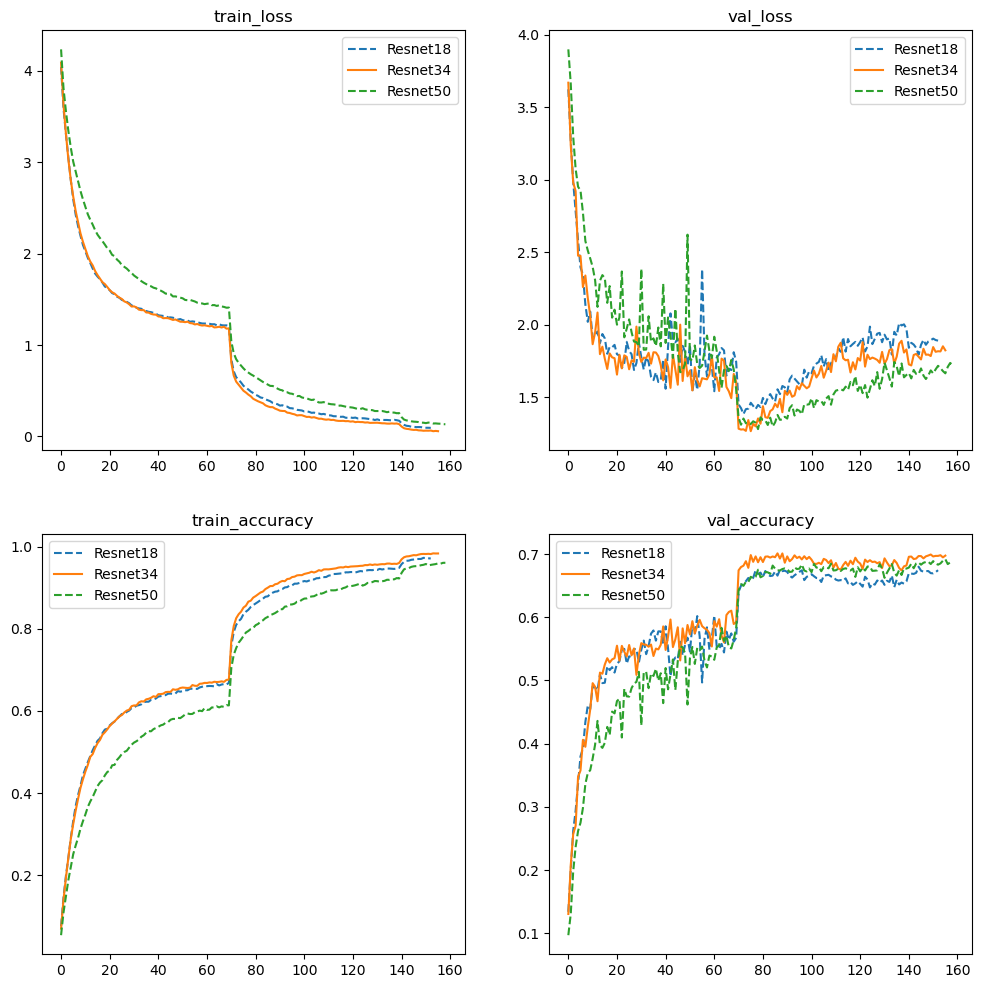

In [6]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.figure(figsize=(12,12))
fields = resnet18_stats.keys()
for i, field in enumerate(fields):
    plt.subplot(2, 2, i+1)
    plt.plot(resnet18_stats[field], label="Resnet18", linestyle="--")
    plt.plot(resnet34_stats[field], label="Resnet34")
    plt.plot(resnet50_stats[field], label="Resnet50", linestyle="--")
    plt.legend()
    plt.title(field)